<a href="https://colab.research.google.com/github/yokahealthcare/Anasa-GAN/blob/master/%5BUdemy%5D%20%5BDCGAN%5D%20MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN - MNIST
## Deep Convolutional Generative Adversial Network

## PART 1 : Data Preparation

### Importing libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.12.0'

### Loading dataset MNIST

In [ ]:
(X_train, Y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
28 * 28

784

### Reshaping the training data (X)
> This must because CNN accept 4-Dimensional Numpy array as input
>
> **STRUCTURE** : (batch_size, height, width, channels)
>
> *Channels can RGB or GRAYSCALE*

In [ ]:
X_train = np.reshape(X_train, (60000, 28, 28, 1)).astype("float")

### Scaling the data into range -1 to 1

In [ ]:
print("max : {} \t min : {}".format(X_train[0].max(), X_train[0].min()))

max : 255.0 	 min : 0.0


In [ ]:
min_value = X_train[0].min()
max_value = X_train[0].max()
# using MinMaxScaler formula and modified it (range : -1 to 1)
X_train = 2 * ((X_train - min_value) / (max_value - min_value)) - 1

In [ ]:
print("max : {} \t min : {}".format(X_train[0].max(), X_train[0].min()))

max : 1.0 	 min : -1.0


### Change X_train to batch type variable

In [ ]:
buffer_size = X_train.shape[0]   # length of data 60.000 row
batch_size = 256
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [ ]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

### Creating build_generator() functions

In [ ]:
def build_generator():
  net = tf.keras.Sequential()
  net.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  net.add(layers.BatchNormalization())
  net.add(layers.LeakyReLU())

  net.add(layers.Reshape((7, 7, 256)))

  # 7 x 7 x 128
  net.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = "same", use_bias = False))
  net.add(layers.BatchNormalization())
  net.add(layers.LeakyReLU())

  # 14 x 14 x 64
  net.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), strides = (2,2), padding = "same", use_bias = False))
  net.add(layers.BatchNormalization())
  net.add(layers.LeakyReLU())

   # 28 x 28 x 1
  net.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), strides = (2,2), padding = "same", use_bias = False, activation = "tanh"))

  net.summary()
  return net

In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.8319619 , -0.622317  ,  0.5765258 , -0.90336114, -0.76183885,
        -1.2754107 ,  0.7047551 , -0.6690951 ,  0.18215777, -0.6015674 ,
        -0.03676174,  0.49068627, -0.622307  ,  1.5561035 , -0.99464536,
        -0.40775195,  1.3982586 ,  0.6975008 , -0.4005011 , -0.7756972 ,
         1.6028887 ,  0.04161678, -0.8635968 , -0.776094  , -1.8251657 ,
         0.40285254, -1.5470164 ,  1.6732163 ,  0.60290295,  1.0032225 ,
        -1.5091627 ,  1.4851221 ,  0.80568504, -0.60398304, -0.03215862,
         0.07744939,  0.45776087,  0.5197713 ,  0.434775  , -1.8904372 ,
         0.76485074, -0.04845679,  0.40371224,  1.0606332 , -0.3809542 ,
        -0.16038549,  0.90784633,  1.2926776 , -0.20593898, -0.26572952,
         0.73903525,  1.4334614 , -0.15121566, -0.7913647 ,  0.4136308 ,
        -0.10758805, -0.10496462, -1.4616283 ,  0.05893357, -0.6920678 ,
        -0.204213  , -0.3795431 ,  0.8005878 , -1.2934746 ,  1.4100475 ,
 

In [ ]:
generated_image = generator(noise, training = False)

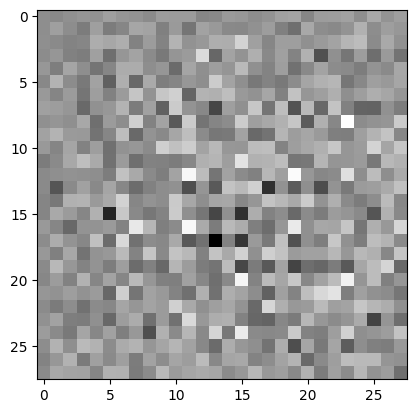

In [ ]:
plt.imshow(generated_image[0], cmap="gray")